In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "serif"

import shared.utils as su

In [2]:
csv_dir = "/scratch/shared/beegfs/piyush/datasets/SimCSE-NLI/final-10112025"
ckp_dir = "/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/"

### Data size

In [115]:
splits = [
    'nli_4500+ego_500-seed_42',
    'nli_9000+ego_1000-seed_42',
    'nli_18000+ego_2000-seed_42',
    'nli_45000+ego_5000-seed_42',
    'nli_90000+ego_10000-seed_42',
    'nli_150000+ego_50000-seed_42',
]

gpu_hours = [
    0.52  * 8,
    1.04  * 8,
    2.08  * 8,
    4.17  * 8,
    8.33  * 8,
    16.66  * 8,
]


df_all = []
for s in su.log.tqdm_iterator(splits, desc='Load results'):
    df = pd.read_csv(f"{csv_dir}/{s}.csv")
    metrics = su.io.load_json(f"{ckp_dir}/{s}/metrics/metrics-ssv2.json")

    df_all.append(
        {
            'split': s, 
            'chiral-t2v': metrics['metrics_pair']['img_map'],
            'chiral-v2t': metrics['metrics_pair']['txt_r1'],
            'nonchiral-t2v': metrics['metrics_stat']['img_map'],
            'nonchiral-v2t': metrics['metrics_stat']['txt_r1'],
            'all-t2v': metrics['metrics_base']['img_map'],
            'all-v2t': metrics['metrics_base']['txt_r1'],
        }
    )
df_all = pd.DataFrame(df_all)

df_all['chiral-avg'] = df_all[['chiral-t2v', 'chiral-v2t']].apply(lambda x: np.mean(x), axis=1)
df_all['nonchiral-avg'] = df_all[['nonchiral-t2v', 'nonchiral-v2t']].apply(lambda x: np.mean(x), axis=1)
df_all['all-avg'] = df_all[['all-t2v', 'all-v2t']].apply(lambda x: np.mean(x), axis=1)
df_all = df_all.round(2)

df_all['total'] = df_all['split'].apply(lambda x: int(x.split('+')[0].split("_")[1]) + int(x.split('+')[1].split('-')[0].split("_")[1]) )
df_all['gpu_hours'] = gpu_hours

df_all.shape

Load results:   0%|          | 0/6 [00:00<?, ?it/s]

(6, 12)

In [116]:
df_all

,split,chiral-t2v,chiral-v2t,nonchiral-t2v,nonchiral-v2t,all-t2v,all-v2t,chiral-avg,nonchiral-avg,all-avg,total,gpu_hours
0,nli_4500+ego_500-seed_42,78.32,81.61,39.96,59.30,30.69,49.30,79.97,49.63,40.00,5000,4.16
1,nli_9000+ego_1000-seed_42,82.92,84.27,39.13,58.46,31.23,47.27,83.59,48.80,39.25,10000,8.32
2,nli_18000+ego_2000-seed_42,85.15,85.31,40.72,60.28,32.52,48.32,85.23,50.50,40.42,20000,16.64
3,nli_45000+ego_5000-seed_42,84.64,84.62,40.09,58.60,31.86,45.52,84.63,49.35,38.69,50000,33.36
4,nli_90000+ego_10000-seed_42,85.67,82.31,42.09,58.18,33.64,45.87,83.99,50.14,39.76,100000,66.64
5,nli_150000+ego_50000-seed_42,85.78,83.36,43.59,55.03,34.62,42.87,84.57,49.31,38.74,200000,133.28


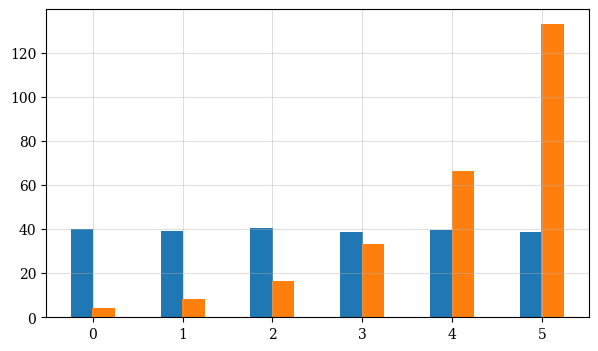

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.grid(alpha=0.4)
ax.bar(x=np.arange(len(df_all))-0.12, height=df_all['all-avg'].tolist(), width=0.25)
ax.bar(x=np.arange(len(df_all))+0.12, height=df_all['gpu_hours'], width=0.25)

# ax.set_ylim(20)
# ax.bar(x=[25000, 50000], height=[10, 20])
plt.show()

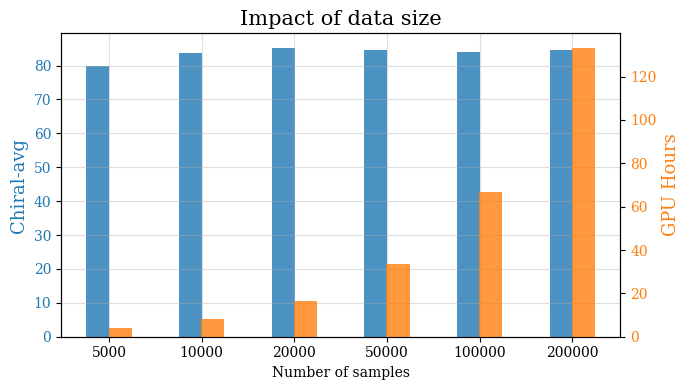

In [120]:
fig, ax1 = plt.subplots(figsize=(7, 4))
ax1.grid(alpha=0.4)

col = 'chiral-avg'

x = np.arange(len(df_all))

# First bar series (left y-axis)
ax1.bar(x - 0.12, df_all[col], width=0.25, label='All-Avg', color='tab:blue', alpha=0.8)
ax1.set_ylabel(col.capitalize(), color='tab:blue', fontsize=13)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Second bar series (right y-axis)
ax2 = ax1.twinx()
ax2.bar(x + 0.12, df_all['gpu_hours'], width=0.25, label='GPU Hours', color='tab:orange', alpha=0.8)
ax2.set_ylabel('GPU Hours', color='tab:orange', fontsize=13)
ax2.tick_params(axis='y', labelcolor='tab:orange')

# X-axis setup
ax1.set_xticks(x)
ax1.set_xticklabels(df_all['total'])  # or another label column if desired

ax1.set_xlabel('Number of samples')
ax1.set_title("Impact of data size", fontsize=15)

su.visualize.increase_font_sizes(ax, 1.3)
fig.tight_layout()
plt.savefig("../figures/datasize-v1.pdf", bbox_inches='tight')
plt.show()


(80.0, 87.0)

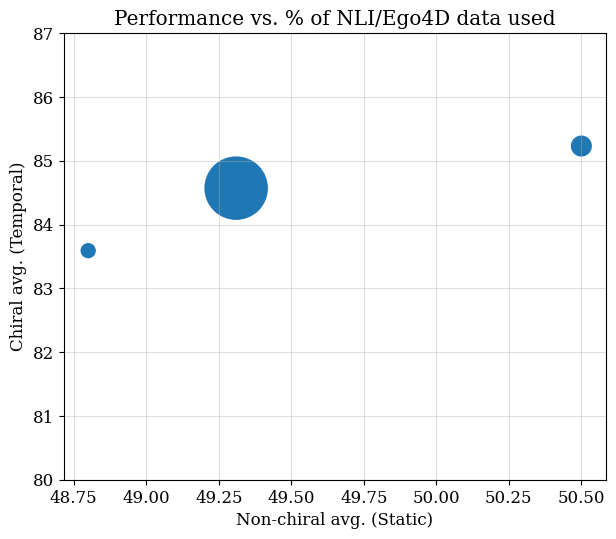

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(7., 5.8))

ax.scatter(df_all['nonchiral-avg'], df_all['chiral-avg'], s=df_all['total'] / 100)
# delta = 0.15
# for i, r in enumerate(df_all["nli_frac"]):
#     ax.text(df_all['nonchiral-avg'].iloc[i]+delta, df_all['chiral-avg'].iloc[i]+delta, f"{r:.1f}", fontsize=12)


ax.grid(alpha=0.4)
ax.set_xlabel('Non-chiral avg. (Static)')
ax.set_ylabel('Chiral avg. (Temporal)')
ax.set_title("Performance vs. % of NLI/Ego4D data used")

su.visualize.increase_font_sizes(ax, 1.2)
ax.set_ylim(80, 87)

### Data composition

In [48]:
splits = [
    'nli_0+ego_10000-seed_42',
    'nli_1000+ego_9000-seed_42',
    'nli_2000+ego_8000-seed_42',
    'nli_3000+ego_7000-seed_42',
    'nli_4000+ego_6000-seed_42',
    'nli_5000+ego_5000-seed_42',
    'nli_6000+ego_4000-seed_42',
    'nli_7000+ego_3000-seed_42',
    'nli_8000+ego_2000-seed_42',
    'nli_9000+ego_1000-seed_42',
    # 'nli_9000+ego_1000+subj_replaced-seed_42'
    'nli_10000+ego_0-seed_42'
]
df_all = []
for s in su.log.tqdm_iterator(splits, desc='Load results'):
    df = pd.read_csv(f"{csv_dir}/{s}.csv")
    metrics = su.io.load_json(f"{ckp_dir}/{s}/metrics/metrics-ssv2.json")

    df_all.append(
        {
            'split': s, 
            'chiral-t2v': metrics['metrics_pair']['img_map'],
            'chiral-v2t': metrics['metrics_pair']['txt_r1'],
            'nonchiral-t2v': metrics['metrics_stat']['img_map'],
            'nonchiral-v2t': metrics['metrics_stat']['txt_r1'],
            'all-t2v': metrics['metrics_base']['img_map'],
            'all-v2t': metrics['metrics_base']['txt_r1'],
        }
    )
df_all = pd.DataFrame(df_all)

df_all['chiral-avg'] = df_all[['chiral-t2v', 'chiral-v2t']].apply(lambda x: np.mean(x), axis=1)
df_all['nonchiral-avg'] = df_all[['nonchiral-t2v', 'nonchiral-v2t']].apply(lambda x: np.mean(x), axis=1)
df_all['all-avg'] = df_all[['all-t2v', 'all-v2t']].apply(lambda x: np.mean(x), axis=1)
df_all = df_all.round(2)

df_all.shape

Load results:   0%|          | 0/11 [00:00<?, ?it/s]

(11, 10)

In [49]:
df_all

,split,chiral-t2v,chiral-v2t,nonchiral-t2v,nonchiral-v2t,all-t2v,all-v2t,chiral-avg,nonchiral-avg,all-avg
0,nli_0+ego_10000-seed_42,71.68,81.40,26.69,46.85,19.88,37.83,76.54,36.77,28.86
1,nli_1000+ego_9000-seed_42,76.38,82.66,33.16,53.57,24.62,43.85,79.52,43.36,34.23
2,nli_2000+ego_8000-seed_42,77.29,82.87,35.42,56.29,26.81,47.55,80.08,45.86,37.18
3,nli_3000+ego_7000-seed_42,79.90,81.26,37.24,58.32,29.07,46.50,80.58,47.78,37.79
4,nli_4000+ego_6000-seed_42,83.99,84.41,40.26,57.34,31.77,46.92,84.20,48.80,39.35
5,nli_5000+ego_5000-seed_42,84.37,83.71,39.94,58.11,31.79,47.76,84.04,49.02,39.78
6,nli_6000+ego_4000-seed_42,82.84,84.90,38.32,57.20,29.93,47.27,83.87,47.76,38.60
7,nli_7000+ego_3000-seed_42,82.34,84.76,37.92,55.38,29.81,44.83,83.55,46.65,37.32
8,nli_8000+ego_2000-seed_42,83.41,85.80,39.36,60.84,31.41,48.81,84.60,50.10,40.11
9,nli_9000+ego_1000-seed_42,82.92,84.27,39.13,58.46,31.23,47.27,83.59,48.80,39.25


In [50]:
df_all['nli_frac'] = df_all['split'].apply(lambda x: 1-int(x.split('+')[0].split("_")[1]) / 10000.)
df_all['nli_frac']

0     1.0
1     0.9
2     0.8
3     0.7
4     0.6
5     0.5
6     0.4
7     0.3
8     0.2
9     0.1
10    0.0
Name: nli_frac, dtype: float64

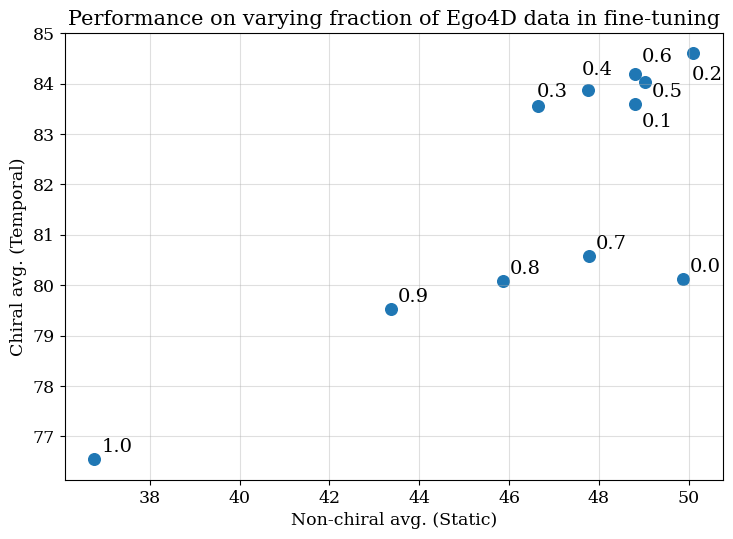

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8.5, 5.8))

s = 65
s = 70
ax.scatter(df_all['nonchiral-avg'], df_all['chiral-avg'], s=s)
delta = 0.15
for i, r in enumerate(df_all["nli_frac"]):
    r = np.round(r, 1)
    x = df_all['nonchiral-avg'].iloc[i]
    y = df_all['chiral-avg'].iloc[i]
    # print(r)
    if r == 0.1:
        # print(r)
        # ax.scatter(x, y, color='tab:orange', s=65)
        x += delta
        y -= 3 * delta
        # ax.text(x, y, f"{r:.1f}", fontsize=14, color='tab:orange')
        ax.text(x, y, f"{r:.1f}", fontsize=14)
    elif r == 0.5:
        x += delta
        y -= 2 * delta
        ax.text(x, y, f"{r:.1f}", fontsize=14)
    elif r == 0.6:
        x += delta
        y += 1.5 * delta
        ax.text(x, y, f"{r:.1f}", fontsize=14)
    elif r == 0.3:
        x -= 0.2 * delta
        y += 1.2 * delta
        ax.text(x, y, f"{r:.1f}", fontsize=14)
    elif r == 0.4:
        x -= delta
        y += 2 * delta
        ax.text(x, y, f"{r:.1f}", fontsize=14)
    elif r == 0.2:
        x -= 0.3 * delta
        y -= 3.5 * delta
        ax.text(x, y, f"{r:.1f}", fontsize=14)
    else:
        x += delta
        y += delta
        ax.text(x, y, f"{r:.1f}", fontsize=14)


ax.grid(alpha=0.4)
ax.set_xlabel('Non-chiral avg. (Static)')
ax.set_ylabel('Chiral avg. (Temporal)')
ax.set_title("Performance on varying fraction of Ego4D data in fine-tuning")
su.visualize.increase_font_sizes(ax, 1.25)

plt.savefig("../figures/ablation_egofrac-v2.pdf", bbox_inches='tight', dpi=400)
plt.show()

### Comparison with EPIC and Charades

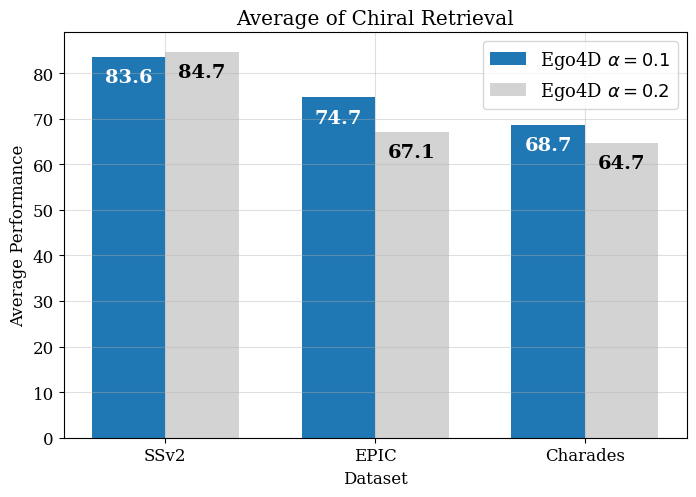

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Data
datasets = ['SSv2', 'EPIC', 'Charades']
ego4d_frac = [0.1, 0.2]

# Values for each dataset and frac (average of 'chiral-v2t' and 'chiral-t2v')
values = {
    0.1: [ (84.3 + 82.9)/2, (76.9 + 72.4)/2, (71.4 + 65.9)/2 ],
    0.2: [ (85.8 + 83.6)/2, (68.4 + 65.8)/2, (67.1 + 62.2)/2 ]
}

x = np.arange(len(datasets))
width = 0.35

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

rects1 = ax.bar(x - width/2, values[0.1], width, label='Ego4D $\\alpha{=}0.1$', color='tab:blue')
rects2 = ax.bar(x + width/2, values[0.2], width, label='Ego4D $\\alpha{=}0.2$', color='lightgray')

# Add labels
colors = ['white', 'black']
j = 0
for rects in [rects1, rects2]:
    color = colors[j]
    j += 1
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width()/2, height - 2.5,  # slightly below top
            f'{height:.1f}', ha='center', va='top', color=color, fontsize=14, fontweight='bold'
        )

# Labels and style
ax.set_ylabel('Average Performance')
ax.set_xlabel('Dataset')
ax.set_title('Average of Chiral Retrieval')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend(fontsize=13)
ax.grid(alpha=0.4)

plt.tight_layout()
su.visualize.increase_font_sizes(ax, 1.2)
plt.savefig("../figures/compare_alpha_0.1_0.2.pdf", bbox_inches='tight')
plt.show()

### Seeds

In [89]:
from glob import glob


files = glob(f"{ckp_dir}/nli_9000+ego_1000-seed_*/")
# files = glob(f"{ckp_dir}/nli_18000+ego_2000-seed_*/")
df_seeds = []
for f in files:
    path = f"{f}/metrics/metrics-ssv2.json"
    if not os.path.exists(path):
        continue
    metrics = su.io.load_json(path)
    seed = int(f.split('/')[-2].split("_")[-1])
    df_seeds.append(
            {
                'seed': seed, 
                'chiral-t2v': metrics['metrics_pair']['img_map'],
                'chiral-v2t': metrics['metrics_pair']['txt_r1'],
                'nonchiral-t2v': metrics['metrics_stat']['img_map'],
                'nonchiral-v2t': metrics['metrics_stat']['txt_r1'],
                'all-t2v': metrics['metrics_base']['img_map'],
                'all-v2t': metrics['metrics_base']['txt_r1'],
            }
        )
df_seeds = pd.DataFrame(df_seeds).round(2)
df_seeds

,seed,chiral-t2v,chiral-v2t,nonchiral-t2v,nonchiral-v2t,all-t2v,all-v2t
0,1,84.38,83.78,39.06,58.32,31.49,45.59
1,21,83.11,85.24,39.17,59.93,31.36,48.39
2,63,83.94,84.34,40.11,58.60,32.09,46.36
3,42,82.92,84.27,39.13,58.46,31.23,47.27
4,84,83.87,84.06,40.10,59.09,32.29,46.57


In [90]:
df_seeds.mean(), df_seeds.std()

(seed             42.200
 chiral-t2v       83.644
 chiral-v2t       84.338
 nonchiral-t2v    39.514
 nonchiral-v2t    58.880
 all-t2v          31.692
 all-v2t          46.836
 dtype: float64,
 seed             32.889208
 chiral-t2v        0.610270
 chiral-v2t        0.549290
 nonchiral-t2v     0.540953
 nonchiral-v2t     0.654790
 all-t2v           0.469169
 all-v2t           1.055121
 dtype: float64)

In [91]:
string = ''
for k in ['chiral-v2t','nonchiral-v2t','all-v2t', 'chiral-t2v','nonchiral-t2v', 'all-t2v']:
    string += "$%s_{ \pm %s }$ & " % (np.round(df_seeds[k].mean(), 1), np.round(df_seeds[k].std(), 1))
print(string)

$84.3_{ \pm 0.5 }$ & $58.9_{ \pm 0.7 }$ & $46.8_{ \pm 1.1 }$ & $83.6_{ \pm 0.6 }$ & $39.5_{ \pm 0.5 }$ & $31.7_{ \pm 0.5 }$ & 
